In [1]:
import qiskit as qk
import qinfer as qf
from qiskit.aqua.algorithms.single_sample import IQPE,QPE
from qiskit.aqua.components import iqfts
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.components.initial_states import Custom
import numpy as np
from qiskit import Aer,execute
from qiskit.aqua import QuantumInstance
# We need distributions to model priors.
from qinfer import distributions
# The noisy coin model has already been implmented, so let's import it here.
from qinfer.test_models import NoisyCoinModel
# Next, we need to import the sequential Monte Carlo updater class.
from qinfer.smc import SMCUpdater
# We'll be demonstrating approximate likelihood evaluation (ALE) as well.
from qinfer import ale
from qinfer import FiniteOutcomeModel
import matplotlib.pyplot as plt
from scipy.stats import circmean

In [2]:
EPS = 1e-15
def chop(value):
    if np.abs(value) <= EPS:
        return 0
    else:
        return value

In [79]:
print(angle)

2.0943951023931953


In [108]:
angle = np.pi / 3
real = chop(np.real(np.exp(1.j * angle)))
imag = chop(np.imag(np.exp(1.j * angle)))

PAULI_DICT_ZZ = {
    'paulis': [
        {"coeff": {"imag": imag, "real": real}, "label": "ZZ"}
    ]
}
QUBIT_OP_ZZ = WeightedPauliOperator.from_dict(PAULI_DICT_ZZ)
eigen_results = ExactEigensolver(QUBIT_OP_ZZ,4).run()
eigen_value = eigen_results['eigvals'][0]
eigen_vector = eigen_results['eigvecs'][0]

In [109]:
eigen_results

{'eigvals': array([-0.5-0.8660254j, -0.5-0.8660254j,  0.5+0.8660254j,  0.5+0.8660254j]),
 'eigvecs': array([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]]),
 'energy': -0.5000000000000001,
 'wavefunction': array([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]]),
 'energies': array([-0.5, -0.5,  0.5,  0.5])}

In [110]:
state_in = Custom(QUBIT_OP_ZZ.num_qubits, state_vector=eigen_vector)

In [111]:
simulator = Aer.get_backend('qasm_simulator')

# IQPE on ZZ unitary

In [112]:
iqpe_builder = IQPE(
    QUBIT_OP_ZZ,
    state_in,
    num_iterations=6,
    num_time_slices=1,
    expansion_mode='suzuki',
    expansion_order=3,
    shallow_circuit_concat=True)
iqpe_results = iqpe_circ = iqpe_builder.run(simulator,shots=2048)

In [113]:
iqpe_results
output_results = iqpe_results['top_measurement_label']

In [114]:
output_results

'010000'

In [115]:
iqpe_results

{'translation': 1.0,
 'stretch': 0.5,
 'top_measurement_label': '010000',
 'phase': 0.25,
 'top_measurement_decimal': 0.25,
 'energy': -0.5}

# QInfer

In [116]:
class IQPEModel(FiniteOutcomeModel):
    
    def __init__(self):
        super(IQPEModel, self).__init__()

    ## PROPERTIES ##

    @property
    def n_modelparams(self):
        # phi
        return 1

    @property
    def expparams_dtype(self):
#         return [('theta','float64'), ('m','int64'),('T2','float64')]
        return [('theta','float64'), ('m','int64')]

    @property
    def is_n_outcomes_constant(self):
        return True

    ## METHODS ##

    @staticmethod
    def are_models_valid(modelparams):
        return np.logical_and(modelparams[:] >= 0, modelparams[:]<=2*np.pi).all(axis=1)

    def n_outcomes(self, expparams):
        return 2

    def likelihood(self, outcomes, modelparams, expparams):
        # We first call the superclass method, which basically
        # just makes sure that call count diagnostics are properly
        # logged.
        super(IQPEModel, self).likelihood(outcomes, modelparams, expparams)
        # Probability of getting 0 for QPE is
        # P(0) = (1 + cos(M(theta - phi)))/2
#         pr0 = np.exp(-expparams['m'] / expparams['T2']) * (1 + np.cos(expparams['m'] * (expparams['theta'] - modelparams[:]))) / 2 + (1 - np.exp(-expparams['m'] / expparams['T2']))/2
        pr0 = (1 + np.cos(expparams['m'] * (expparams['theta'] - modelparams[:]))) / 2

        # Concatenate over outcomes.
        return FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

In [117]:
N_PARTICLES = 5000
N_EXP = 20
N_TRIALS = 1

In [118]:
prior = distributions.UniformDistribution([0, 2 * np.pi])
# prior = distributions.NormalDistribution(np.pi,0.5)
model = IQPEModel()

In [119]:
performance_dtype = [
    ('outcome', 'i1'),
    ('est_mean', 'f8'), ('est_cov_mat', 'f8'),
    ('true_err', 'f8'), ('resample_count', 'i8'),
    ('elapsed_time', 'f8'),
    ('like_count', 'i8'), ('sim_count', 'i8'),
    ('bme', 'f8'),
    ('var', 'f8'),
    ('bme_err', 'f8')
]

In [120]:
performance = np.empty((N_TRIALS, N_EXP), dtype=performance_dtype)

In [121]:
true_params = np.empty((N_TRIALS, model.n_modelparams))

Now, we run the experiments!

In [122]:
import time

In [123]:
def radiandiff(a,b):
    FULL_ROTATION = 2 * np.pi
    return np.min(np.abs([a - b, b - a, a - b + FULL_ROTATION, b - a + FULL_ROTATION]))

In [130]:
THETA = np.pi/3
# M = np.linspace(1,5)
# n = 2
# expected_bit = np.float64(output_results[-n])
M = 3
T2 = 100
# expparams = np.array([(M,THETA,T2)], dtype=model.expparams_dtype)
expparams = np.array([(M,THETA)], dtype=model.expparams_dtype)

In [131]:
class PhaseSMCUpdater(SMCUpdater):
    @staticmethod
    def particle_mean(weights,locations):
        weighted_values = np.multiply(weights, locations)
        return circmean(weighted_values)

In [132]:
simulator = Aer.get_backend('qasm_simulator')

In [133]:
for idx_trial in range(N_TRIALS):
    
    # First, make new updaters using the constructors
    # defined above.
    updater = PhaseSMCUpdater(model, N_PARTICLES, prior)
    
#     # Sample true set of modelparams.
#     truemp = prior.sample()
#     true_params[idx_trial, :] = truemp

    # Now loop over experiments, updating each of the
    # updaters with the same data, so that we can compare
    # their estimation performance.
    print(idx_trial)
    circuit = iqpe_builder.construct_circuit(k=M,omega=THETA,measurement=True)
    results = execute(circuit,simulator,shots=4096,memory=True)
    counts = results.result().get_counts()
    memory = results.result().get_memory()
    print(counts)
    for idx_exp in range(N_EXP):
        
        # Make a short hand for indexing the current simulation
        # and experiment.
        idxs = np.s_[idx_trial, idx_exp]
        # Start by simulating and recording the data.
        
        #########################################
        #########################################
        #########################################
        #########################################
        #########################################
        #########################################
        #########################################
        #########################################
        USE_QISKIT_QASM_SIMULATOR = False
        if USE_QISKIT_QASM_SIMULATOR:
            outcome = int(memory[idx_exp])
        else:
            outcome = model.simulate_experiment(np.array([[angle]]),expparams)
        #########################################
        #########################################
        #########################################
        #########################################
        #########################################
        #########################################
        #########################################
        #########################################
        
        performance['outcome'][idxs] = outcome
#         print(outcome)
    
        # Reset the like_count and sim_count
        # properties so that we can count how many were used
        # by this update. Note that this is a hack;
        # an appropriate method should be added to
        # Simulatable.
        model._sim_count = 0
        model._call_count = 0
            
        # Time the actual update.
        tic = toc = None
        tic = time.time()
        updater.update(outcome, expparams)
        performance[idxs]['elapsed_time'] = time.time() - tic
        
        # Record the performance of this updater.
#         weighted_values = np.multiply(updater.particle_weights, updater.particle_locations)
#         est_mean = circmean(weighted_values)
        est_mean = updater.est_mean()
        performance[idxs]['est_mean'] = est_mean
        performance[idxs]['true_err'] = radiandiff(est_mean,angle) ** 2
#         performance[idxs]['true_err'] = np.abs(est_mean - truemp) ** 2
        performance[idxs]['est_cov_mat'] = updater.est_covariance_mtx()
        performance[idxs]['resample_count'] = updater.resample_count
        performance[idxs]['like_count'] = model.call_count
        performance[idxs]['sim_count'] = model.sim_count
        
#         Finally, record the ideal stats.
#         performance[idxs]['bme'], performance[idxs]['var'] = exactBME(
#             idx_exp + 1 - np.sum(performance[idxs]['outcome']), idx_exp + 1,
#             ALPHA, BETA
#         )
#         performance[idxs]['bme'], 

#         performance[idxs]['bme_err'] = np.abs(performance[idxs]['bme'] - truemp) ** 2
print('Done!')

0
{'0': 3082, '1': 1014}
Done!


In [134]:
# plt.semilogy(np.mean(performance['true_err'],axis=0))

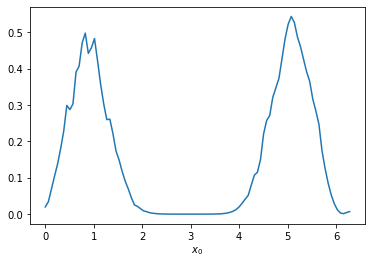

In [135]:
updater.plot_posterior_marginal()

In [ ]:
counts

# Derived Model Example

In [ ]:
def averageofcounts(counts):
#     print(dir(counts))
    sum = 0
    count = 0
    for k,v in counts.items():
        key_val = int(k)
        sum += key_val * v
        count += v
    return sum / count

In [ ]:
model = IQPEModel()
n_meas = 25
prior = distributions.UniformDistribution([0, 1])
updater = PhaseSMCUpdater(model, 2000, prior)
heuristic = qf.ExpSparseHeuristic(updater)
true_params = 1
est_hist = []
for m in range(25):
    print('Infering for m=%d' % (m))
    THETA = np.pi
    M = 4
    T2 = 100
    experiment = np.array([(M,THETA,T2)], dtype=model.expparams_dtype)
#     experiment = np.array([(m, n_meas)], dtype=model.expparams_dtype)
#     datum = model.simulate_experiment(true_params, experiment)
    
    circuit = iqpe_builder.construct_circuit(k=M,omega=THETA,measurement=True)
    n_shots = 4096
    results = execute(circuit,simulator,shots=n_shots)
    counts = results.result().get_counts()
    datum = averageofcounts(counts)
#     print(datum)
    
    updater.update(datum, experiment)
    est_hist.append(updater.est_mean())
plt.plot(est_hist, label='Est.')
plt.hlines(true_params, 0, 20, label='True')
plt.legend(ncol=2)
plt.xlabel('# of Times Sampled (25 measurements/ea)')
plt.ylabel('Measured value')